## Project to Weed Detection in Soybean Crops
#### The dataset was get in [Kaggle](https://www.kaggle.com/fpeccia/weed-detection-in-soybean-crops)

### Steps
#### Configuration
- Download dataset
- Configure os enviroments
- Imports dependencies
- Create global variables
- Get images from dataset
- Show image
- Split dataset to train and test

#### Start Learning with Keras
- Import keras
- Create callbacks (savePoint, reduce)
- Create a model for CNN
- Compile model
- Load model if exists
- Train model
- Evaluate model
- Fit model
- Show results

#### Reference :
[Kaggle notebook](https://www.kaggle.com/harshel7/detecting-malaria-val-accuracy-97)

In [1]:
import os   
os.environ['HDF5_DISABLE_VERSION_CHECK']='1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# Imports here
#https://www.kaggle.com/datduyn/2-layer-net-on-weeds-discriminant/
##https://www.kaggle.com/harshel7/detecting-malaria-val-accuracy-97
import cv2                 
import numpy as np   
import glob
import matplotlib.pyplot as plt 
from random import shuffle

In [10]:
data_dir = r'dataset/'
classes = ['broadleaf', 'grass', 'soil', 'soybean'] 
width = 128
height = 128
channel = 3

num_file_per_directory = 1800 

all_files = [] 
for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file_per_directory]

print('Files size:', len(all_files))

data = []
labels = []
for idx, file in enumerate(all_files):
    img_array = cv2.resize(cv2.imread(file), (width, height))
    data.append(img_array)
    if 'broadleaf' in file :
        labels.append(0)
    elif 'grass' in file :
        labels.append(1)
    elif 'soil' in file :
        labels.append(2)
    else :
        labels.append(3)


Files size: 6591


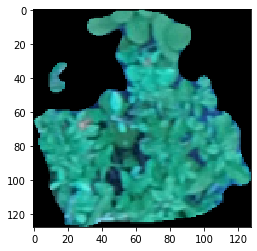

In [11]:
plt.imshow(data[0])
plt.show()

In [12]:
image_data = np.array(data)
labels = np.array(labels)
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

from sklearn.model_selection import train_test_split
x_train_full, x_test, y_train_full, y_test = train_test_split(image_data, labels, test_size = 0.25, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, random_state=42)


### Start Learning with Keras

Documantation [keras](https://keras.io/)

In [6]:
from keras.utils import np_utils
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from keras.preprocessing import image
import os.path

y_train = np_utils.to_categorical(y_train, num_classes = 4)
y_test = np_utils.to_categorical(y_test, num_classes = 4)

Using TensorFlow backend.


In [7]:
filepath="keras_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='auto')

In [8]:
lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.2,
                              patience=3, min_lr=0.003)

In [9]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3,3), activation = 'relu', padding="SAME"))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.4))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [10]:
model = CNNbuild(height = height, width = width, classes = len(classes), channels = channel)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)       

In [11]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [12]:
def loadModel() :
    if os.path.isfile(filepath):
        model.load_weights(filepath)
loadModel()

In [13]:
h = model.fit(x_train, y_train, epochs = 20, batch_size = 32, shuffle=True, callbacks=[lr_reduce, checkpoint])

Epoch 1/20
3707/3707 [==============================] - 142s 38ms/step - loss: 0.2795 - accuracy: 0.8972

Epoch 00001: accuracy improved from -inf to 0.89722, saving model to keras_model.h5
Epoch 2/20
3707/3707 [==============================] - 118s 32ms/step - loss: 0.2512 - accuracy: 0.9040

Epoch 00002: accuracy improved from 0.89722 to 0.90397, saving model to keras_model.h5
Epoch 3/20
3707/3707 [==============================] - 101s 27ms/step - loss: 0.2413 - accuracy: 0.9091

Epoch 00003: accuracy improved from 0.90397 to 0.90909, saving model to keras_model.h5
Epoch 4/20
3707/3707 [==============================] - 119s 32ms/step - loss: 0.2213 - accuracy: 0.9185

Epoch 00004: accuracy improved from 0.90909 to 0.91853, saving model to keras_model.h5
Epoch 5/20
3707/3707 [==============================] - 149s 40ms/step - loss: 0.2201 - accuracy: 0.9204

Epoch 00005: accuracy improved from 0.91853 to 0.92042, saving model to keras_model.h5
Epoch 6/20
3707/3707 [================

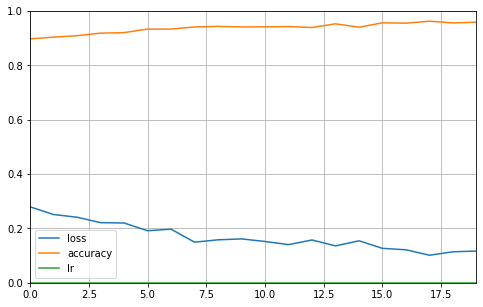

In [14]:
import pandas as pd
pd.DataFrame(h.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [15]:
loadModel()

In [16]:
predictions = model.evaluate(x_test, y_test)

1648/1648 [==============================] - 18s 11ms/step


In [17]:
print(f'LOSS : {predictions[0]}')
print(f'ACCURACY : {predictions[1]}')

LOSS : 0.21858093064748546
ACCURACY : 0.9241504669189453


Mean =  13


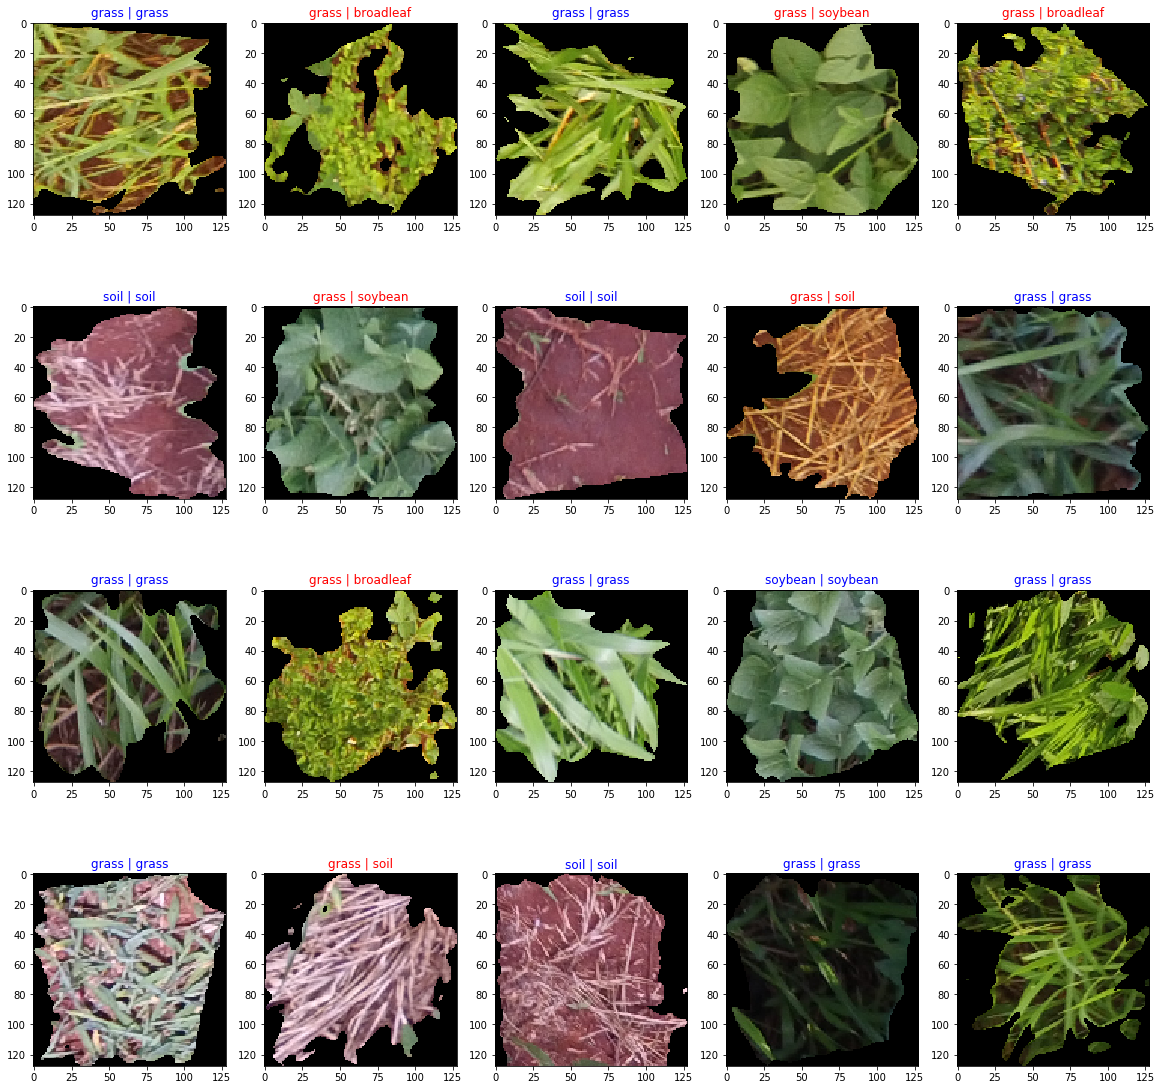

In [30]:
qtdElements = 20
batch_holder = np.zeros((qtdElements, width, height, 3))
correct_label = [0] * qtdElements
shuffle(all_files)
for i,file, in enumerate(all_files[0:qtdElements]):
    correct_label[i] = file.split("/")[1].split("\\")[0]
    img = image.load_img(file, target_size=(width,height))
    batch_holder[i, :] = img
    
result = model.predict_classes(batch_holder)

mean = qtdElements
fig = plt.figure(figsize=(20, 20))
for i,img in enumerate(batch_holder):
    fig.add_subplot(4,5, i+1)
    title = classes[result[i]] + ' | ' + correct_label[i]
    color = 'blue'
    if classes[result[i]] != correct_label[i] :
        color = 'red'
        mean -=1;
    plt.title(title, color=color)
    plt.imshow(img/256.)

print('Mean = ', mean)
plt.show()

### Lib Versions

In [19]:
import tensorflow
import matplotlib
import keras
print('Tensorflow:', tensorflow.__version__)
print('Keras:', keras.__version__)
print('Numpy:', np.__version__)
print('Matplotlib:', matplotlib.__version__)

Tensorflow: 2.0.0
Keras: 2.3.1
Numpy: 1.16.5
Matplotlib: 3.1.1
